In [383]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os
import gsw
from cmocean import cm
from datetime import datetime, timedelta
from dateutil.parser import parse
from salishsea_tools import viz_tools, utilities, places
from itertools import repeat
from scipy.signal import butter, lfilter

%matplotlib inline

In [369]:
HRDPS = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSaSurfaceAtmosphereFieldsV1')
mask = xr.open_dataset('/data/bmoorema/MEOPAR/grid/mesh_mask201702.nc')
paths = {
    'loadpath': '/results/SalishSea/hindcast.201812',
    'loadpath_cutoff': '/results2/SalishSea/hindcast.201812_annex',
    'savepath': '/ocean/bmoorema/research/MEOPAR/analysis-ben/data/SalishSeaCast',
    'date_cutoff': '2016 Nov 21',
}

In [119]:
def make_prefix(date, paths, res='h'):
    """
    """
    
    datestr = date.strftime('%Y%m%d')
    path = paths['loadpath']
    if paths['date_cutoff'] is not None:
        if date >= parse(paths['date_cutoff']):
            path = paths['loadpath_cutoff']
    fn = '_'.join(['SalishSea', f'1{res}', *repeat(datestr, 2), ''])
    prefix = os.path.join(path, date.strftime('%d%b%y').lower(), fn)
    
    return prefix

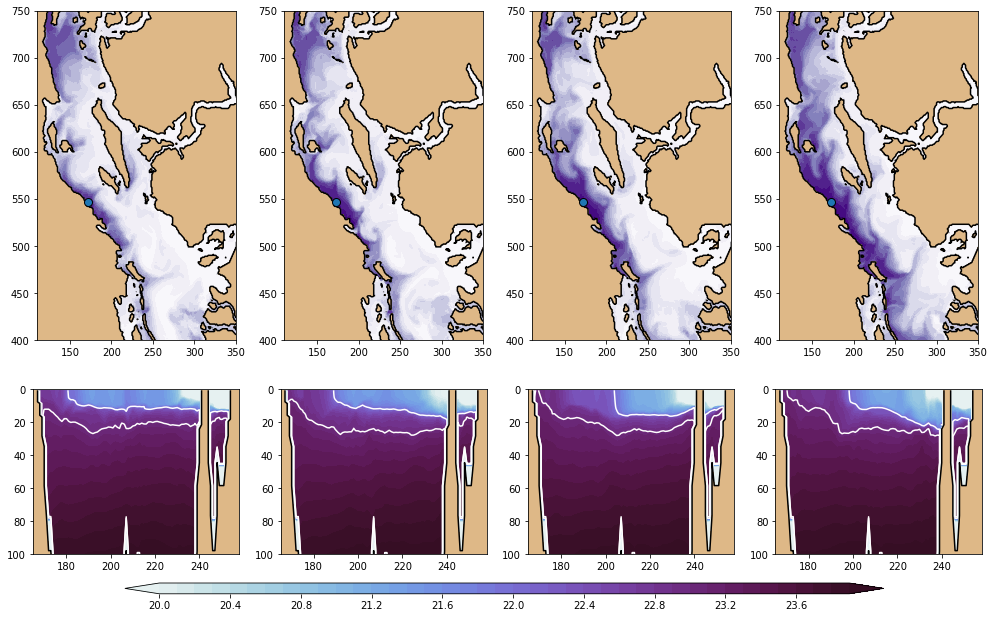

In [256]:
fig, axs = plt.subplots(2, 4, figsize=(17, 10), gridspec_kw={'height_ratios': [2, 1]})
cax = fig.add_axes([0.2, 0.07, 0.62, 0.015])

for ax, hour in zip(axs.T, range(0, 82, 20)):
    date = datetime(2018, 4, 6) + timedelta(hours=hour)
    prefix = make_prefix(date, paths)

    # Plot NEMO data
    with xr.open_dataset(prefix + 'ptrc_T.nc').sel(time_counter=date, method='nearest') as data:
        c = ax[0].contourf(data.x, data.y, data.nitrate[0, ...], levels=np.arange(0, 30, 2), cmap=plt.get_cmap('Purples'), extend='both')
    ax[0].contourf(mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='Burlywood')
    ax[0].contour(mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
    ax[0].plot(*loc[2:][::-1], 'o', markeredgecolor='k', markersize=8)
    ax[0].set_xlim([110, 350])
    ax[0].set_ylim([400, 750])
    viz_tools.set_aspect(ax[0])
    
    with xr.open_dataset(prefix + 'grid_T.nc').sel(time_counter=date, method='nearest') as data:
        sigma = gsw.rho(data.vosaline[:, 550, :], data.votemper[:, 550, :], np.expand_dims(data.deptht, axis=1)) - 1000
        c = ax[1].contourf(data.x, data.deptht, sigma, levels=np.arange(20, 24, 0.1), cmap=cm.dense, extend='both')
        ax[1].contour(data.x, data.deptht, sigma, levels=[22, 23], colors='w')
    ax[1].contourf(data.x, data.deptht, mask.tmask[0, :, 550, :], levels=[-0.01, 0.01], colors='Burlywood')
    ax[1].contour(data.x, data.deptht, mask.tmask[0, :, 550, :], levels=[-0.01, 0.01], colors='k')
    ax[1].set_xlim([165, 258])
    ax[1].set_ylim([100, 0])
fig.colorbar(c, cax=cax, orientation='horizontal')

## Isolating upwelling metrics from density cross-sections

In [773]:
# Upwelling event date windows
events = [[parse(date) for date in window] for window in [
    ['2015 Mar 10', '2015 Mar 18'],
    ['2015 Mar 18', '2015 Apr 1'],
    ['2015 Apr 25', '2015 Apr 30'],
    ['2015 Aug 26', '2015 Sept 3'],
    ['2015 Oct 6', '2015 Oct 14'],
    #['2016 Apr 5', '2016 Apr 8'],
    ['2016 Apr 10', '2016 Apr 15'],
    #['2016 Aug 28', '2016 Sep 4'],
    ['2017 Apr 3', '2017 Apr 12'],
    ['2017 May 30', '2017 Jun 5'],
    ['2017 Sep 8', '2017 Sep 13'],
    ['2017 Sep 16', '2017 Sep 20'],
    ['2017 Oct 14', '2017 Oct 25'],
    ['2018 Mar 21', '2018 Mar 28'],
    ['2018 Apr 2', '2018 Apr 16'],
    ['2018 Sep 7', '2018 Sep 19'],
    ['2018 Oct 22', '2018 Nov 3'],
    
]]

Loading ... N/A% (14 of N/A) |#                                            |Time: 0:44:06


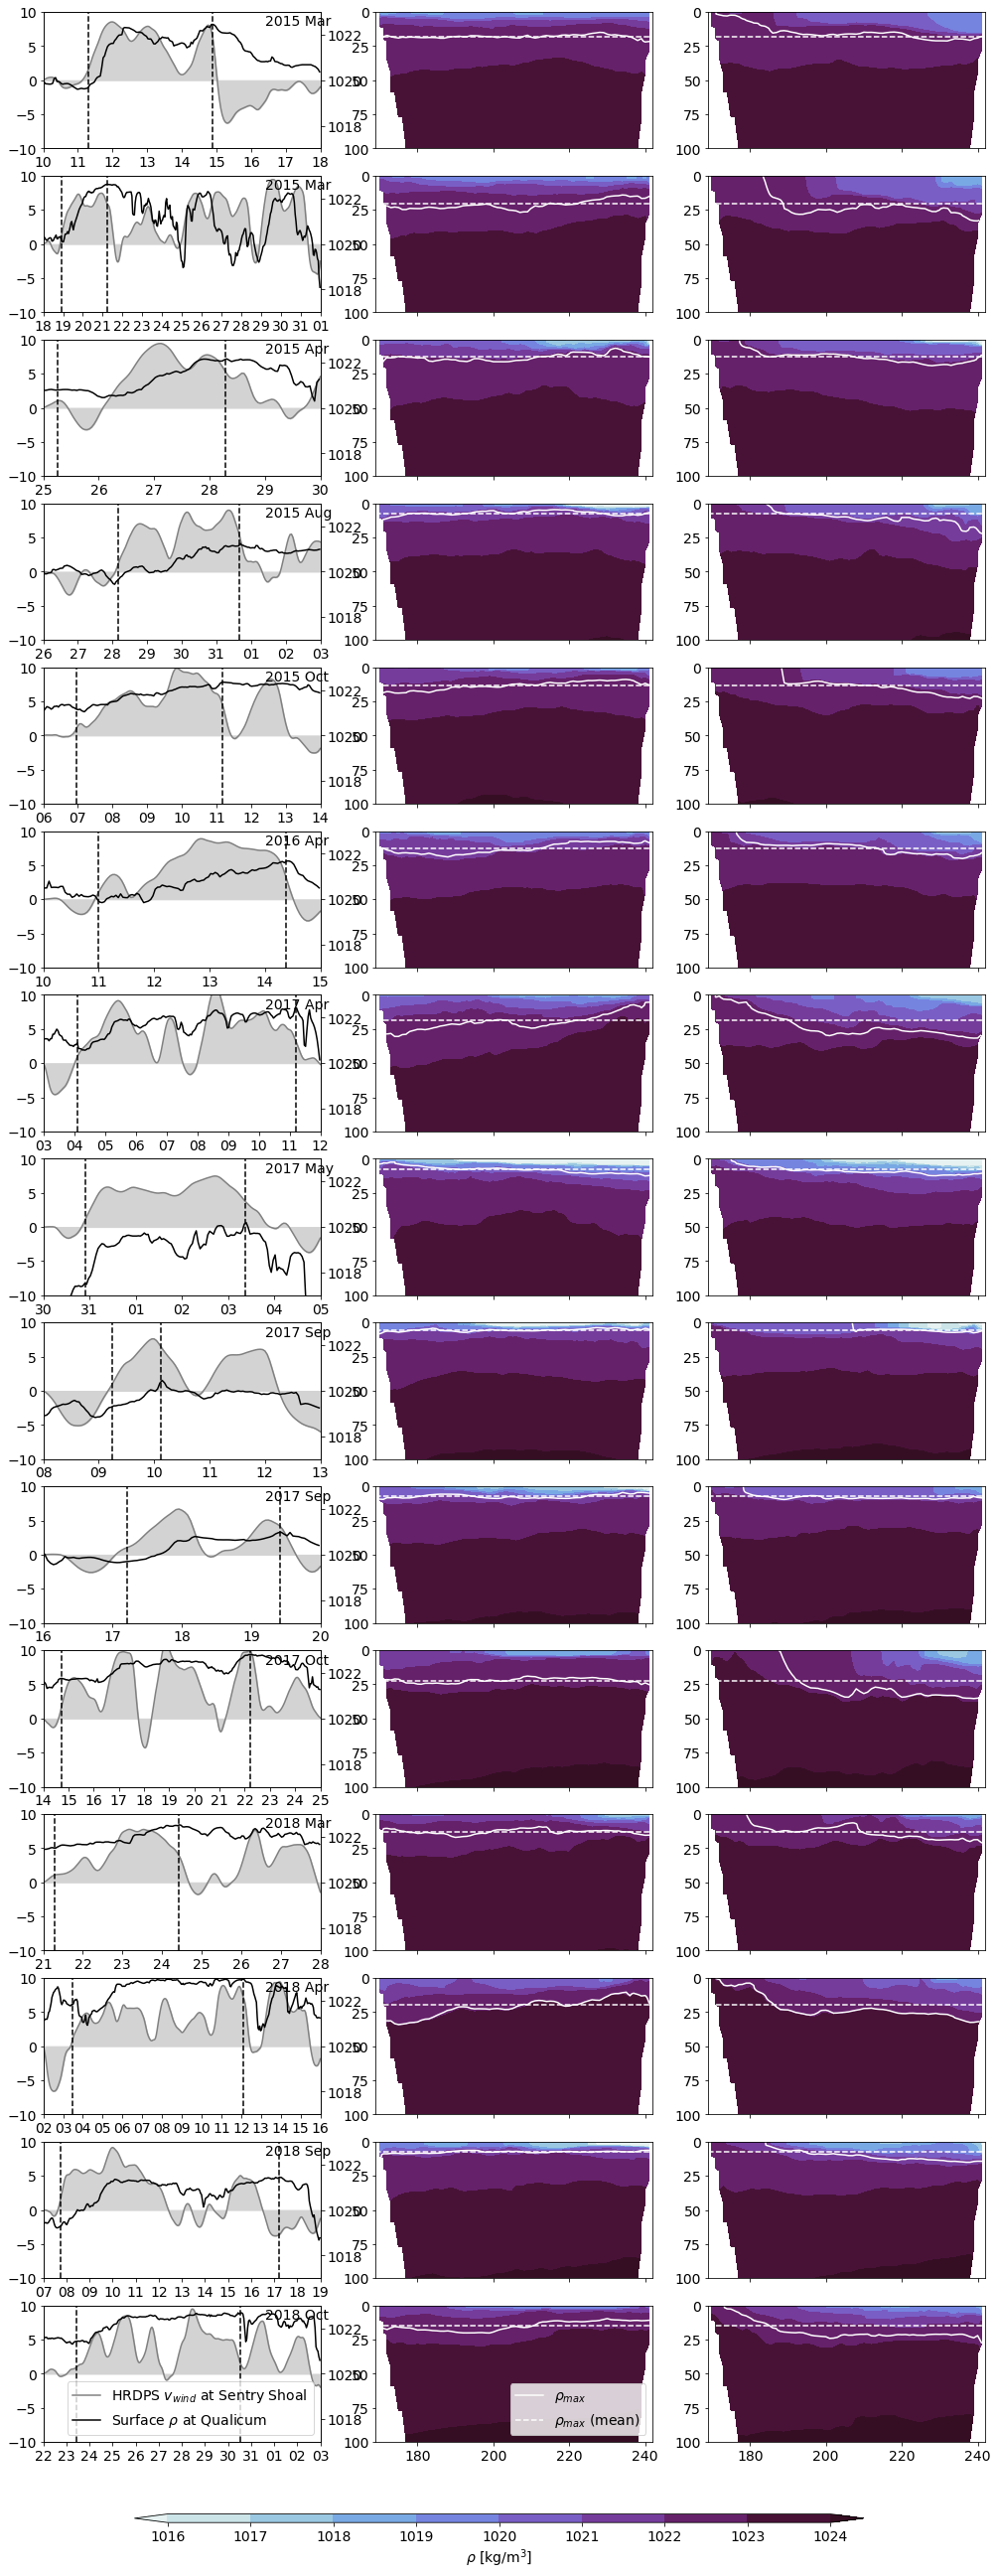

In [774]:
timerange = [datetime(2015, 3, 10), datetime(2015, 4, 1)]
xlim = [169, 242]
loc = (slice(None), 0, 547, slice(*xlim))
keys = ['vosaline', 'votemper']
j, i = places.PLACES['Sentry Shoal']['GEM2.5 grid ji']
metrics = {}
n_events = len(events)

# tau x
# T x
# N x
# D_c x
# rho_0
# D x

# Make figure
fig = plt.figure(figsize=(17, 3 * n_events))
gs = plt.GridSpec(n_events, 3)
cax = fig.add_axes([0.2, 0.1, 0.6, 0.04/n_events])

# Loop through events
bar = utilities.statusbar('Loading ...')
for row, event in bar(zip(range(n_events), events)):

    # Event name
    eventname = event[0].strftime('%Y%m%d')
    
    # Generate rho timeseries
    time = np.empty(0, dtype='datetime64')
    rho = np.empty(0)
    for day in range(np.diff(event)[0].days):
        prefix = make_prefix(event[0] + timedelta(days=day), paths)
        with xr.open_dataset(prefix + 'grid_T.nc') as data:
            time = np.concatenate((time, data.time_counter.values))
            rho = np.concatenate((rho, gsw.rho(*[data[k][loc].values.max(axis=1) for k in keys], 0)))
    
    # Extract and filter wind record
    v_time = HRDPS.time.sel(time=slice(*event)).values
    v_wind = HRDPS.v_wind.sel(time=slice(*event))[:, j, i].values
    fs = 1 / 3600
    cutoff = 1 / 86400 / 1
    v_filt = lfilter(*butter(2, cutoff / fs / 0.5, btype='lowpass'), v_wind)
    
    # Plot wind and surface density
    ax = fig.add_subplot(gs[row, 0])
    ax.set_xlim(event)
    ax.set_ylim([-10, 10])
    ax.fill_between(v_time, v_filt, color='lightgray')
    l1 = ax.plot(v_time, v_filt, color='gray', label='HRDPS $v_{wind}$ at Sentry Shoal')
    ax2 = ax.twinx()
    l2 = ax2.plot(time, rho, color='k', label='Surface $\\rho$ at Qualicum')
    ax2.set_ylim([1017, 1023])
    ax.text(0.8, 0.9, event[0].strftime('%Y %b'), transform=ax.transAxes)
    ax.xaxis.set_major_locator(mdates.DayLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d'))
    if row == n_events - 1:
        lns = l1 + l2
        ax.legend(lns, [l.get_label() for l in lns], loc=4)
    
    # Record metrics
    hour_peak = int(rho.argmax())
    hour_onset = int((v_filt > 1).argmax())
    metrics[eventname] = {
        'rho_max': max(rho),
        'hour_peak': hour_peak,
        'hour_onset': hour_onset,
        'tau_max': 1.225e-3 * v_filt[hour_onset:hour_peak].max()**2
    }
    
    # Plot onset and peak rho
    for k in ['hour_onset', 'hour_peak']:
        timestamp = HRDPS.time.sel(time=event[0] + timedelta(hours=metrics[eventname][k])).values
        ax.plot(list(repeat(timestamp, 2)), [-10, 10], 'k--')

    # Isolate start and max density cross-sections
    for col, hour in zip(range(1, 3), ['hour_onset', 'hour_peak']):

        # Construct density cross-section
        date = event[0] + timedelta(hours=metrics[eventname][hour])
        prefix = make_prefix(date, paths)
        data = xr.open_dataset(prefix + 'grid_T.nc')
        rho_0 = gsw.rho(*[np.ma.masked_where(
            mask.tmask[0, :, loc[2], :] == 0, data[k].sel(time_counter=date, method='nearest')[:, loc[2], :],
        ) for k in keys], np.expand_dims(data.deptht, axis=1))
        N2 = 9.81 * 1e-3 * np.diff(rho_0, axis=0) / np.expand_dims(mask.e3t_1d[0, 1:], axis=1)
        if hour is 'hour_onset':
            metrics[eventname]['N2_max'] = N2.max()
            metrics[eventname]['N2_depth'] = data.deptht.values[1:][np.where(N2.mean(axis=1) > 2e-4)][-1]

        # Make axes and plot formatting
        ax = fig.add_subplot(gs[row, col])
        ax.set_xlim(xlim)
        ax.set_ylim([100, 0])
            
        # Create contour of rho_max
        c = ax.contour(data.x[slice(*xlim)], data.deptht, rho_0[:, slice(*xlim)], levels=[metrics[eventname]['rho_max']])
        c_max = []
        for contour in c.collections[0].get_paths():
            if len(contour) > len(c_max): c_max = contour.vertices
        c.collections[0].remove()

        # Plot contours
        ax.plot(c_max[:, 0], c_max[:, 1], 'w-', label='$\\rho_{max}$')
        if hour is 'hour_onset':
            max_depth = c_max[:, 1].mean()
            metrics[eventname]['rho_max_depth'] = max_depth
        ax.plot(xlim, [max_depth, max_depth], 'w--', label='$\\rho_{max}$ (mean)')
        
        # Plot rho contours
        c = ax.contourf(
            data.x[slice(*xlim)], data.deptht, rho_0[:, slice(*xlim)],
            levels=np.arange(1016, 1025, 1), cmap=cm.dense, extend='both', zorder=0,
        )
        
        # Plot legend and suppress tick labels
        if row < n_events - 1:
            ax.xaxis.set_ticklabels('')
        else:
            if hour is 'hour_onset': ax.legend(loc=4)
            
fig.colorbar(c, cax=cax, orientation='horizontal', label='$\\rho$ [kg/m$^3$]')
plt.show()

In [776]:
metrics['20150310']

{'N2_depth': 28.229916,
 'N2_max': 0.013481727354391838,
 'hour_onset': 31,
 'hour_peak': 117,
 'rho_max': 1022.4512451433546,
 'rho_max_depth': 17.93740570973228,
 'tau_max': 0.08929084470173972}

Loading ... 100% (15 of 15) |##############################################|Time: 0:00:00


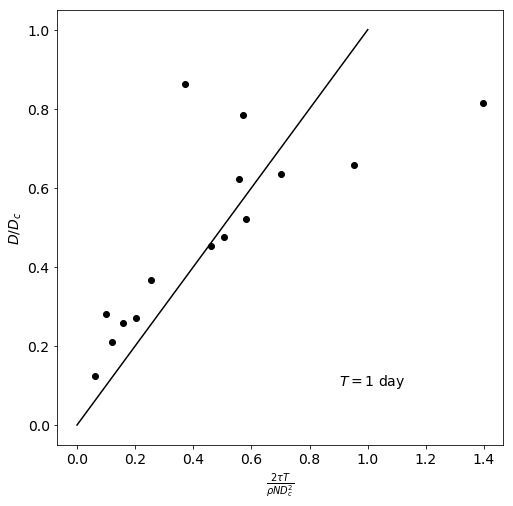

In [787]:
fig, ax = plt.subplots(1, figsize=(8, 8))
ax.plot([0, 1], [0, 1], 'k')
ax.set_xlabel('$\\frac{2\\tau T}{\\rho N D_c^2}$')
ax.set_ylabel('$D/D_c$')
ax.text(0.9, 0.1, '$T = 1$ day')
bar = utilities.statusbar('Loading ...')
for n, event in enumerate(bar(events)):
    eventname = event[0].strftime('%Y%m%d')
    D_calc = 86400 * metrics[eventname]['tau_max'] / (metrics[eventname]['rho_max'] * metrics[eventname]['N2_max'] * metrics[eventname]['N2_depth']**2)
    D_model = metrics[eventname]['rho_max_depth'] / metrics[eventname]['N2_depth']
    #date = event[0] + timedelta(hours=metrics[eventname]['hour_onset'])
    #U = HRDPS.v_wind.sel(time=slice(date, date + timedelta(hours=48)))[:, j, i].values.mean()
    ax.plot(D_calc, D_model, 'ko')

## Scaling arguments

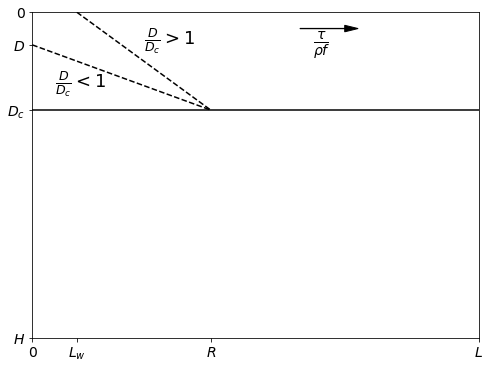

In [689]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])

ax.plot([0, 1], [0.7, 0.7], 'k-')
ax.plot([0, 0.4], [0.9, 0.7], 'k--')
ax.plot([0.1, 0.4], [1, 0.7], 'k--')

ax.xaxis.set_ticks([0, 0.1, 0.4, 1])
ax.xaxis.set_ticklabels([0, '$L_w$', '$R$', '$L$'])
ax.yaxis.set_ticks([0, 0.7, 0.9, 1])
ax.yaxis.set_ticklabels(['$H$', '$D_c$', '$D$', 0])

ax.arrow(0.6, 0.95, 0.1, 0, head_width=0.02, color='k')
ax.text(0.63, 0.89, '$\\frac{\\tau}{\\rho f}$', size=20)
ax.text(0.05, 0.77, '$\\frac{D}{D_c} < 1$', size=18)
ax.text(0.25, 0.9, '$\\frac{D}{D_c} > 1$', size=18)

plt.show()

### Depth of upwelling

Conservation of mass (Ekman flux over time equals pycnocline displacement)

$$\frac{DR}{2} = \frac{\tau T}{\rho f}$$

where $R = ND_c/f$

Thus

$$\frac{D}{D_c} = \frac{2\tau T}{\rho ND_c^2}$$

Incidentally, Csanady (1982) gives evolving wind setup as

$$\xi = \frac{u_*^2t}{c}e^{x/R}$$

which simplifies to the same relation along the coast.

### Upwelling flux

When $D/D_c = 1$

$$\frac{D_c\left(R + L_w\right)}{2} = \frac{\tau T}{\rho f}$$

Considering again R

$$\frac{L_w}{R} = \frac{2\tau T}{\rho ND_c^2} - 1$$